This notebook shows an example causal mediation analysis by patching intermediate representations between a factually correct and a factually incorrect predictions made by a GPT model.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import seaborn as sns
from matplotlib import pyplot as plt


# change model_dir into the local directory of your own GPT2-XL model
model_dir = "/home/leiyu/scratch/cma_hallucination/models/gpt2-xl/"
num_layers = 48
num_attn_heads = 25
mlp_hidden_dim = 6400
hs_hidden_dim = 1600
module_cma_batch_size = 600  # works for a single A100 GPU with 48GB memory

tokenizer = AutoTokenizer.from_pretrained(model_dir)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained(model_dir).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

The following code block defines the patching functions. 

Each batch_inputs contains a batch of (1 + seq_len * n_layer) input sequences, with the first one being a "clean" prompt whose intermediate states computed by the GPT will be patched onto the other (seq_len * n_layer) corrupted inputs, where each corrupted input has exactly one of its intermediate hidden states being patched.

The type of intermediate hidden state to patch can be 1) hidden word contextualized embeddings(hs); 2) the attention module outputs (attn) added into the residual stream; and 3) the MLP module outputs added into the residual stream. 

In [2]:
torch.set_grad_enabled(False)

def untuple(x):
    return x[0] if isinstance(x, tuple) else x


def trace_with_token_patch(model, batch_inputs,
                           patch_layer_idx, patch_token_idx,
                           patch_state_kind,
                           true_answer_id, hall_answer_id):
    patch_hooks = []

    def make_token_patch_hook(patch_batch_id, patch_token_id):
        def token_patch_hook(module, inputs, outputs):
            outputs_0 = untuple(outputs)
            outputs_0[patch_batch_id, patch_token_id] = outputs_0[0, patch_token_id]
            return outputs

        return token_patch_hook

    for i in range(len(patch_layer_idx)):
        patch_layer_id = int(patch_layer_idx[i])
        patch_token_id = patch_token_idx[i]
        patch_batch_id = 1 + i
        if patch_state_kind == 'hs':
            hook = model.transformer.h[patch_layer_id].register_forward_hook(
                make_token_patch_hook(patch_batch_id, patch_token_id))
        elif patch_state_kind == 'attn':
            hook = model.transformer.h[patch_layer_id].attn.register_forward_hook(
                make_token_patch_hook(patch_batch_id, patch_token_id))
        elif patch_state_kind == 'mlp':
            hook = model.transformer.h[patch_layer_id].mlp.register_forward_hook(
                make_token_patch_hook(patch_batch_id, patch_token_id))
        else:
            raise ValueError('Invalid patching module name.')
        patch_hooks.append(hook)

    # With the patching rules defined, run the patched model in inference.
    with torch.no_grad():
        outputs_exp = model(**batch_inputs)
    for hook in patch_hooks:
        hook.remove()

    # We report likelihood ratios between the true and the hallucinated token predictions.
    logits_true = outputs_exp.logits[:, -1, true_answer_id]  # (seq_len * n_layers)
    logits_hall = outputs_exp.logits[:, -1, hall_answer_id]  # (seq_len * n_layers)
    llrs = torch.exp(logits_hall - logits_true).cpu()[1:]  # (seq_len * n_layers)

    return llrs

In [3]:
prompt_fact = 'Yesterday I visited The CN Tower located in downtown'
prompt_hall = 'I am from Quebec. Yesterday I visited The CN Tower located in downtown'

inputs_fact = tokenizer(
    [prompt_fact], 
    padding=True,    
    return_tensors='pt'
).to(device)

inputs_hall = tokenizer(
    [prompt_hall], 
    padding=True,    
    return_tensors='pt'
).to(device)

with torch.no_grad():
    outputs_fact = model(**inputs_fact)
    outputs_hall = model(**inputs_hall)
    pred_fact = torch.argsort(-outputs_fact.logits[0, -1])[0].cpu()
    pred_hall = torch.argsort(-outputs_hall.logits[0, -1])[0].cpu()
    print('model prediction for factual prompt:', tokenizer.decode(pred_fact))
    print('model prediction for hallucinated prompt:', tokenizer.decode(pred_hall))

model prediction for factual prompt:  Toronto
model prediction for hallucinated prompt:  Montreal


In [4]:
data = {
    'original prompt': prompt_fact,
    'tuned prompt': prompt_hall
}

true_answer_id = pred_fact
hall_answer_id = pred_hall

seq_len_orig = len(tokenizer(data['original prompt'])['input_ids'])
seq_len_tuned = len(tokenizer(data['tuned prompt'])['input_ids'])
n_pad = seq_len_tuned - seq_len_orig

batch_inputs_ie = tokenizer(
    [data['original prompt']] + [data['tuned prompt']] * (num_layers * seq_len_orig),
    return_tensors='pt',
    padding=True
)
batch_inputs_de = tokenizer(
    [data['tuned prompt']] + [data['original prompt']] * (num_layers * seq_len_orig),
    return_tensors='pt',
    padding=True
)

position_ids_orig = torch.tensor([0]*n_pad + list(range(seq_len_orig)))
position_ids_tuned = torch.tensor(list(range(seq_len_tuned)))

batch_inputs_ie['position_ids'] = torch.cat(
    [position_ids_orig.unsqueeze(0), position_ids_tuned.repeat(num_layers * seq_len_orig, 1)]
)
batch_inputs_de['position_ids'] = torch.cat(
    [position_ids_tuned.unsqueeze(0), position_ids_orig.repeat(num_layers * seq_len_orig, 1)]
)

patch_layer_idx = torch.repeat_interleave(
    torch.arange(num_layers), seq_len_orig
)

patch_token_idx = n_pad + torch.arange(seq_len_orig).repeat(num_layers)

We compute and illustrate the "direct effects" of each network module in causing halluciated outputs.

I.e. we run the prompt with hallucinated model response as clean run, and patch each of its intermediate states onto the computation graph of a prompt that the model answers correctly, and see how much change in the likelihood ratio between the factual and the hallucinated objects will take place after patching a particular state.

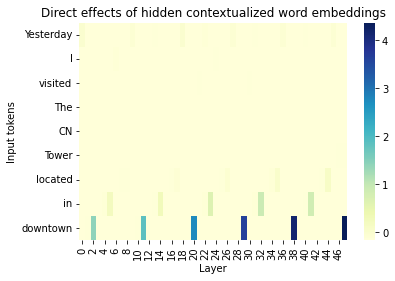

In [26]:
# direct effects of patching intermediate contextualized word embeddings
prompt_tokens = tokenizer.convert_ids_to_tokens(tokenizer(prompt_fact)['input_ids'])
prompt_tokens = [x.replace('Ġ', '') for x in prompt_tokens]

batch_inputs = batch_inputs_de.to(device)
patch_state_kind = 'hs'

llrs = trace_with_token_patch(model, batch_inputs,
                              patch_layer_idx, patch_token_idx,
                              patch_state_kind,
                              true_answer_id, hall_answer_id)


llrs_diff = (llrs.view(seq_len_orig, num_layers) - llrs[0]).numpy()

ax = sns.heatmap(llrs_diff, cmap="YlGnBu")
ax.set_xlabel('Layer')
ax.set_ylabel('Input tokens')
ax.set_yticklabels(prompt_tokens, rotation=360)
ax.set_title('Direct effects of hidden contextualized word embeddings')

plt.show()

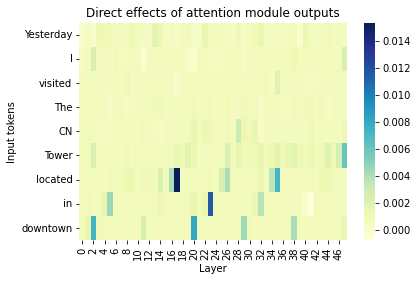

In [27]:
# direct effects of patching intermediate attention module outputs

batch_inputs = batch_inputs_de.to(device)
patch_state_kind = 'attn'

llrs = trace_with_token_patch(model, batch_inputs,
                              patch_layer_idx, patch_token_idx,
                              patch_state_kind,
                              true_answer_id, hall_answer_id)


llrs_diff = (llrs.view(seq_len_orig, num_layers) - llrs[0]).numpy()

ax = sns.heatmap(llrs_diff, cmap="YlGnBu")
ax.set_xlabel('Layer')
ax.set_ylabel('Input tokens')
ax.set_yticklabels(prompt_tokens, rotation=360)
ax.set_title('Direct effects of attention module outputs')

plt.show()

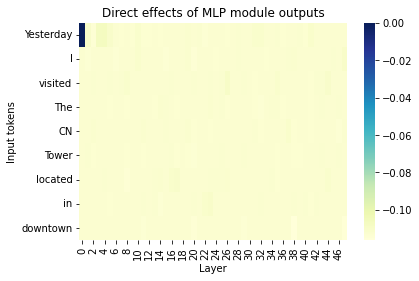

In [28]:
# direct effects of patching intermediate MLP module outputs

batch_inputs = batch_inputs_de.to(device)
patch_state_kind = 'mlp'

llrs = trace_with_token_patch(model, batch_inputs,
                              patch_layer_idx, patch_token_idx,
                              patch_state_kind,
                              true_answer_id, hall_answer_id)


llrs_diff = (llrs.view(seq_len_orig, num_layers) - llrs[0]).numpy()

ax = sns.heatmap(llrs_diff, cmap="YlGnBu")
ax.set_xlabel('Layer')
ax.set_ylabel('Input tokens')
ax.set_yticklabels(prompt_tokens, rotation=360)
ax.set_title('Direct effects of MLP module outputs')

plt.show()